In [1]:
from matplotlib import pyplot as plt
from whar_datasets.adapters.sampler import WHARSampler
from whar_datasets.support.getter import WHARDatasetID, get_whar_cfg

In [2]:
cfg = get_whar_cfg(WHARDatasetID.UCI_HAR)
sampler = WHARSampler(cfg, override_cache=False)

Creating config hash...
Checking download...
Download exists.
Checking sessions...
Sessions exist.
Validating common format...
[########################################] | 100% Completed | 854.04 ms
Common format validated.
Checking windowing...
Loading config hash...
Windowing exists.
subject_ids: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
activity_ids: [0 1 2 3 4 5]


In [3]:
sampler.prepare(scv_group_index=0)

Postprocessing...


Loading windows: 100%|██████████| 9499/9499 [00:07<00:00, 1210.97it/s]


Getting normalization parameters...
Loading config hash...
Creating normalization parameters hash...
Loading normalization parameters hash...


Loading samples: 100%|██████████| 9499/9499 [00:02<00:00, 3904.97it/s]


In [5]:
weights = sampler.get_class_weights(sampler.train_indices)
print(weights)

{2: 0.8292814459578982, 0: 0.8537360102227118, 1: 0.9104131038433669, 3: 1.002926213702739, 5: 1.1338565288075355, 4: 1.2697866974657486}


subject_id
5    257
Name: count, dtype: int64
activity_id
3    76
Name: count, dtype: int64
torch.Size([1]) torch.Size([1, 128, 9])


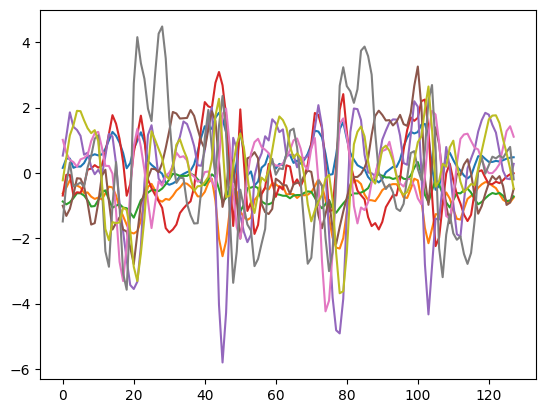

In [8]:
y, x = sampler.sample(1, sampler.train_indices, subject_id=5, activity_id=3, seed=None)
print(y.shape, x.shape)

plt.plot(x[0])
plt.show()